In [8]:
import torch
from torch import nn
from torch.nn import functional as F
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
from functools import reduce
from tqdm.auto import tqdm
import copy
import os

ImportError: TensorBoard logging requires TensorBoard with Python summary writer installed. This should be available in 1.14 or above.

In [1]:
device="cuda:0" if torch.cuda.is_available() else "cpu"
device

NameError: name 'torch' is not defined

In [ ]:
base_path="<data>/{}"
DATA_PATH = os.path.join("..", "data")

In [2]:
df_energy=pd.read_csv(base_path.format("energy_dataset.csv"))
df_energy.loc["time",:]=pd.to_datetime(df_energy["time"])
df_energy=df_energy.set_index("time")
df_energy=df_energy.drop("price day ahead",axis=1)
df_energy.head()

NameError: name 'pd' is not defined

In [12]:
print(df_energy.head())

NameError: name 'df_energy' is not defined

In [0]:
df_weather=pd.read_csv(base_path.format("weather_features.csv"))
df_weather.loc["dt_iso",:]=pd.to_datetime(df_weather["dt_iso"])
dfs_weather_city=[df.set_index("dt_iso") for _,df in df_weather.groupby(["city_name"])]

In [9]:
dfs_weather_city[0].head()

,city_name,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id,weather_main,weather_description,weather_icon
dt_iso,,,,,,,,,,,,,,,,
2015-01-01 00:00:00+01:00,Barcelona,281.625,281.625,281.625,1035.0,100.0,7.0,58.0,0.0,0.0,0.0,0.0,800.0,clear,sky is clear,01n
2015-01-01 01:00:00+01:00,Barcelona,281.625,281.625,281.625,1035.0,100.0,7.0,58.0,0.0,0.0,0.0,0.0,800.0,clear,sky is clear,01n
2015-01-01 02:00:00+01:00,Barcelona,281.286,281.286,281.286,1036.0,100.0,7.0,48.0,0.0,0.0,0.0,0.0,800.0,clear,sky is clear,01n
2015-01-01 03:00:00+01:00,Barcelona,281.286,281.286,281.286,1036.0,100.0,7.0,48.0,0.0,0.0,0.0,0.0,800.0,clear,sky is clear,01n
2015-01-01 04:00:00+01:00,Barcelona,281.286,281.286,281.286,1036.0,100.0,7.0,48.0,0.0,0.0,0.0,0.0,800.0,clear,sky is clear,01n


In [10]:
df=reduce(lambda x,y: pd.merge(x,y,left_index=True,right_index=True),[df_energy]+dfs_weather_city)
df.head()

,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,generation hydro pumped storage aggregated,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation marine,generation nuclear,generation other,generation other renewable,generation solar,generation waste,generation wind offshore,generation wind onshore,forecast solar day ahead,forecast wind offshore eday ahead,forecast wind onshore day ahead,total load forecast,total load actual,price actual,city_name_x,temp_x,temp_min_x,temp_max_x,pressure_x,humidity_x,wind_speed_x,wind_deg_x,rain_1h_x,rain_3h_x,snow_3h_x,clouds_all_x,weather_id_x,...,rain_1h_x,rain_3h_x,snow_3h_x,clouds_all_x,weather_id_x,weather_main_x,weather_description_x,weather_icon_x,city_name_y,temp_y,temp_min_y,temp_max_y,pressure_y,humidity_y,wind_speed_y,wind_deg_y,rain_1h_y,rain_3h_y,snow_3h_y,clouds_all_y,weather_id_y,weather_main_y,weather_description_y,weather_icon_y,city_name,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id,weather_main,weather_description,weather_icon
2015-01-01 00:00:00+01:00,447.0,329.0,0.0,4844.0,4821.0,162.0,0.0,0.0,0.0,NaN,863.0,1051.0,1899.0,0.0,7096.0,43.0,73.0,49.0,196.0,0.0,6378.0,17.0,NaN,6436.0,26118.0,25385.0,65.41,Barcelona,281.625,281.625,281.625,1035.0,100.0,7.0,58.0,0.0,0.0,0.0,0.0,800.0,...,0.0,0.0,0.0,0.0,800.0,clear,sky is clear,01n,Seville,273.375,273.375,273.375,1039.0,75.0,1.0,21.0,0.0,0.0,0.0,0.0,800.0,clear,sky is clear,01n,Valencia,270.475,270.475,270.475,1001.0,77.0,1.0,62.0,0.0,0.0,0.0,0.0,800.0,clear,sky is clear,01n
2015-01-01 01:00:00+01:00,449.0,328.0,0.0,5196.0,4755.0,158.0,0.0,0.0,0.0,NaN,920.0,1009.0,1658.0,0.0,7096.0,43.0,71.0,50.0,195.0,0.0,5890.0,16.0,NaN,5856.0,24934.0,24382.0,64.92,Barcelona,281.625,281.625,281.625,1035.0,100.0,7.0,58.0,0.0,0.0,0.0,0.0,800.0,...,0.0,0.0,0.0,0.0,800.0,clear,sky is clear,01n,Seville,273.375,273.375,273.375,1039.0,75.0,1.0,21.0,0.0,0.0,0.0,0.0,800.0,clear,sky is clear,01n,Valencia,270.475,270.475,270.475,1001.0,77.0,1.0,62.0,0.0,0.0,0.0,0.0,800.0,clear,sky is clear,01n
2015-01-01 02:00:00+01:00,448.0,323.0,0.0,4857.0,4581.0,157.0,0.0,0.0,0.0,NaN,1164.0,973.0,1371.0,0.0,7099.0,43.0,73.0,50.0,196.0,0.0,5461.0,8.0,NaN,5454.0,23515.0,22734.0,64.48,Barcelona,281.286,281.286,281.286,1036.0,100.0,7.0,48.0,0.0,0.0,0.0,0.0,800.0,...,0.0,0.0,0.0,0.0,800.0,clear,sky is clear,01n,Seville,274.086,274.086,274.086,1039.0,71.0,3.0,27.0,0.0,0.0,0.0,0.0,800.0,clear,sky is clear,01n,Valencia,269.686,269.686,269.686,1002.0,78.0,0.0,23.0,0.0,0.0,0.0,0.0,800.0,clear,sky is clear,01n
2015-01-01 03:00:00+01:00,438.0,254.0,0.0,4314.0,4131.0,160.0,0.0,0.0,0.0,NaN,1503.0,949.0,779.0,0.0,7098.0,43.0,75.0,50.0,191.0,0.0,5238.0,2.0,NaN,5151.0,22642.0,21286.0,59.32,Barcelona,281.286,281.286,281.286,1036.0,100.0,7.0,48.0,0.0,0.0,0.0,0.0,800.0,...,0.0,0.0,0.0,0.0,800.0,clear,sky is clear,01n,Seville,274.086,274.086,274.086,1039.0,71.0,3.0,27.0,0.0,0.0,0.0,0.0,800.0,clear,sky is clear,01n,Valencia,269.686,269.686,269.686,1002.0,78.0,0.0,23.0,0.0,0.0,0.0,0.0,800.0,clear,sky is clear,01n
2015-01-01 04:00:00+01:00,428.0,187.0,0.0,4130.0,3840.0,156.0,0.0,0.0,0.0,NaN,1826.0,953.0,720.0,0.0,7097.0,43.0,74.0,42.0,189.0,0.0,4935.0,9.0,NaN,4861.0,21785.0,20264.0,56.04,Barcelona,281.286,281.286,281.286,1036.0,100.0,7.0,48.0,0.0,0.0,0.0,0.0,800.0,...,0.0,0.0,0.0,0.0,800.0,clear,sky is clear,01n,Seville,274.086,274.086,274.086,1039.0,71.0,3.0,27.0,0.0,0.0,0.0,0.0,800.0,clear,sky is clear,01n,Valencia,269.686,269.686,269.686,1002.0,78.0,0.0,23.0,0.0,0.0,0.0,0.0,800.0,clear,sky is clear,01n


In [0]:
def get_numeric_data(df):
  numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
  return df.select_dtypes(include=numerics)

df=get_numeric_data(df)

In [0]:
def exclude_no_variance(df):
  return df[df.columns[df.var()>0]]

df=exclude_no_variance(df)

In [0]:
def exclude_nan_percentage_more_than(df,threshold=.5):
  selector=(pd.isna(df).sum()/df.shape[0])<threshold
  return df[df.columns[selector]]

df=exclude_nan_percentage_more_than(df,.2)

In [0]:
def fill_nan_with_median(df):
  df = df.groupby(df.columns, axis = 1).transform(lambda x: x.fillna(x.median()))
  return df


df=fill_nan_with_median(df)

In [15]:
df.head()

,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation nuclear,generation other,generation other renewable,generation solar,generation waste,generation wind onshore,forecast solar day ahead,forecast wind onshore day ahead,total load forecast,total load actual,price actual,temp_x,temp_x,temp_x,temp_x,temp_x,temp_x,temp_x,temp_x,temp_min_x,temp_min_x,temp_min_x,temp_min_x,temp_min_x,temp_min_x,temp_min_x,temp_min_x,temp_max_x,temp_max_x,temp_max_x,temp_max_x,temp_max_x,...,rain_1h_y,rain_1h_y,rain_1h_y,rain_1h_y,rain_3h_y,rain_3h_y,rain_3h_y,rain_3h_y,rain_3h_y,rain_3h_y,rain_3h_y,rain_3h_y,clouds_all_y,clouds_all_y,clouds_all_y,clouds_all_y,clouds_all_y,clouds_all_y,clouds_all_y,clouds_all_y,weather_id_y,weather_id_y,weather_id_y,weather_id_y,weather_id_y,weather_id_y,weather_id_y,weather_id_y,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id
2015-01-01 00:00:00+01:00,447.0,329.0,4844.0,4821.0,162.0,863.0,1051.0,1899.0,7096.0,43.0,73.0,49.0,196.0,6378.0,17.0,6436.0,26118.0,25385.0,65.41,281.625,267.325,281.625,267.325,281.625,267.325,281.625,267.325,281.625,267.325,281.625,267.325,281.625,267.325,281.625,267.325,281.625,267.325,281.625,267.325,281.625,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,800.0,800.0,800.0,800.0,800.0,800.0,800.0,800.0,270.475,270.475,270.475,1001.0,77.0,1.0,62.0,0.0,0.0,0.0,0.0,800.0
2015-01-01 01:00:00+01:00,449.0,328.0,5196.0,4755.0,158.0,920.0,1009.0,1658.0,7096.0,43.0,71.0,50.0,195.0,5890.0,16.0,5856.0,24934.0,24382.0,64.92,281.625,267.325,281.625,267.325,281.625,267.325,281.625,267.325,281.625,267.325,281.625,267.325,281.625,267.325,281.625,267.325,281.625,267.325,281.625,267.325,281.625,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,800.0,800.0,800.0,800.0,800.0,800.0,800.0,800.0,270.475,270.475,270.475,1001.0,77.0,1.0,62.0,0.0,0.0,0.0,0.0,800.0
2015-01-01 02:00:00+01:00,448.0,323.0,4857.0,4581.0,157.0,1164.0,973.0,1371.0,7099.0,43.0,73.0,50.0,196.0,5461.0,8.0,5454.0,23515.0,22734.0,64.48,281.286,266.186,281.286,266.186,281.286,266.186,281.286,266.186,281.286,266.186,281.286,266.186,281.286,266.186,281.286,266.186,281.286,266.186,281.286,266.186,281.286,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,800.0,800.0,800.0,800.0,800.0,800.0,800.0,800.0,269.686,269.686,269.686,1002.0,78.0,0.0,23.0,0.0,0.0,0.0,0.0,800.0
2015-01-01 03:00:00+01:00,438.0,254.0,4314.0,4131.0,160.0,1503.0,949.0,779.0,7098.0,43.0,75.0,50.0,191.0,5238.0,2.0,5151.0,22642.0,21286.0,59.32,281.286,266.186,281.286,266.186,281.286,266.186,281.286,266.186,281.286,266.186,281.286,266.186,281.286,266.186,281.286,266.186,281.286,266.186,281.286,266.186,281.286,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,800.0,800.0,800.0,800.0,800.0,800.0,800.0,800.0,269.686,269.686,269.686,1002.0,78.0,0.0,23.0,0.0,0.0,0.0,0.0,800.0
2015-01-01 04:00:00+01:00,428.0,187.0,4130.0,3840.0,156.0,1826.0,953.0,720.0,7097.0,43.0,74.0,42.0,189.0,4935.0,9.0,4861.0,21785.0,20264.0,56.04,281.286,266.186,281.286,266.186,281.286,266.186,281.286,266.186,281.286,266.186,281.286,266.186,281.286,266.186,281.286,266.186,281.286,266.186,281.286,266.186,281.286,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,800.0,800.0,800.0,800.0,800.0,800.0,800.0,800.0,269.686,269.686,269.686,1002.0,78.0,0.0,23.0,0.0,0.0,0.0,0.0,800.0


In [0]:
target_cols=["price actual"]

In [17]:
class TimeSeries:
  def __init__(self,df,target_cols,train_test_split=.2,train_val_split=.1):
    self.df=df
    self.ttsplit=int((1-train_test_split)*df.shape[0])
    print("Train-Test-Split = {}".format(self.ttsplit))
    self.tvsplit=int((1-train_val_split)*self.ttsplit)
    print("Train-Validation-Split = {}".format(self.tvsplit))
    self.target_cols=target_cols

  def sample_train(self,lookback=128):
    end=np.random.choice(self.tvsplit-lookback-1,1)[0]+lookback
    start=end-lookback
    X=self.df.values[start:end]
    y=self.df[self.target_cols].values[end:end+1].reshape(-1)
    return X,y

  def sample_val(self,lookback=128):
    end=np.random.choice(self.ttsplit-self.tvsplit,1)[0]+lookback+self.tvsplit
    start=end-lookback
    X=self.df.values[start:end]
    y=self.df[self.target_cols].values[end:end+1].reshape(-1)
    return X,y

  def sample_test(self,lookback=128):
    end=np.random.choice((self.df.shape[0]-self.ttsplit)-lookback-1,1)[0]+lookback
    start=end-lookback
    X=self.df.values[start:end]
    y=self.df[self.target_cols].values[end:end+1].reshape(-1)
    return X,y

ts=TimeSeries(df,target_cols)
X,y=ts.sample_val()

Train-Test-Split = 30854
Train-Validation-Split = 27768


In [0]:
df.iloc[0]

generation biomass                       447.0
generation fossil brown coal/lignite     329.0
generation fossil gas                   4844.0
generation fossil hard coal             4821.0
generation fossil oil                    162.0
                                         ...  
rain_1h                                    0.0
rain_3h                                    0.0
snow_3h                                    0.0
clouds_all                                 0.0
weather_id                               800.0
Name: 2015-01-01 00:00:00+01:00, Length: 391, dtype: float64

In [18]:
X=[]
y=[]
for _ in tqdm(range(5000)):
  X_,y_=ts.sample_train()
  X.append(X_)
  y.append(y_)

X=torch.FloatTensor(X).to(device)
y=torch.FloatTensor(y).to(device)

In [19]:
X_val=[]
y_val=[]
for _ in tqdm(range(1000)):
  X_,y_=ts.sample_val()
  X_val.append(X_)
  y_val.append(y_)

X_val=torch.FloatTensor(X_val).to(device)
y_val=torch.FloatTensor(y_val).to(device)

In [20]:
X_test=[]
y_test=[]
for _ in tqdm(range(1000)):
  X_,y_=ts.sample_test()
  X_test.append(X_)
  y_test.append(y_)

X_test=torch.FloatTensor(X_test).to(device)
y_test=torch.FloatTensor(y_test).to(device)

In [0]:
class Normalizer(nn.Module):
  def __init__(self,X):
    super().__init__()
    with torch.no_grad():
      self.mu=nn.Parameter(X.reshape(X.shape[0],-1).mean(axis=0))
      self.std=nn.Parameter(X.reshape(X.shape[0],-1).std(axis=0))

  def forward(self,x):
    orig_shape=x.shape
    x=x.reshape(x.shape[0],-1)
    x=(x-self.mu)/(self.std+1e-6)
    x=x.reshape(orig_shape)
    return x

  def reverse(self,x):
    orig_shape=x.shape
    x=x.reshape(x.shape[0],-1)
    x=(x*(self.std+1e-6))+self.mu
    x=x.reshape(orig_shape)
    return x

input_normalizer=Normalizer(X).to(device)
output_normalizer=Normalizer(y).to(device)

In [28]:
X.shape

torch.Size([5000, 128, 391])

In [22]:
output_normalizer(y[0:5]).shape
output_normalizer.reverse(output_normalizer(y[0:5])),y[0:5]

(tensor([[27.3100],
         [39.7200],
         [65.9600],
         [56.1200],
         [61.6600]], device='cuda:0', grad_fn=<ViewBackward>),
 tensor([[27.3100],
         [39.7200],
         [65.9600],
         [56.1200],
         [61.6600]], device='cuda:0'))

In [0]:
class Predictor(nn.Module):
  def __init__(self,X,y):
    super().__init__()
    self.lstm=nn.LSTM(X.shape[-1],64,batch_first=True)
    self.hidden=nn.Sequential(
        nn.LayerNorm(64),
        nn.Linear(64,16),
        nn.ELU(),
        nn.LayerNorm(16),
        nn.Linear(16,8),
        nn.ELU(),
    )
    self.out_mu=nn.Sequential(
        nn.Linear(8,y.shape[-1]),
        nn.Tanh()
    )
    self.out_log_prob=nn.Sequential(
        nn.Linear(8,y.shape[-1]),
        nn.Tanh()
    )

  def forward(self,x):
    _,(x,_)=self.lstm(x)
    x=self.hidden(x)
    x_mu=self.out_mu(x)*4 # data is normalized to mu 0+-std 1
    x_log_prob=self.out_log_prob(x)*4
    return torch.distributions.Normal(x_mu,x_log_prob.exp())


predictor=Predictor(X,y).to(device)


In [25]:
predictor(input_normalizer(X_test[:100])).log_prob(output_normalizer(y_test[:100])).mean()

tensor(-15.4161, device='cuda:0', grad_fn=<MeanBackward0>)

In [0]:
lr=1e-4
optimizer=torch.optim.Adam(predictor.parameters(),lr=lr)

In [27]:
last_val_scores=[]
last_val_scores_max_size=4
lr_decay=.95
lr=1e-3
optimizer=torch.optim.Adam(predictor.parameters(),lr=lr)

best_params=copy.deepcopy(predictor.state_dict())
best_params_score=np.inf

for step in tqdm(range(100000)):

  #train step
  idx=np.random.choice(X.shape[0],128)
  dist=predictor(input_normalizer(X[idx]))
  log_probs=dist.log_prob(output_normalizer(y[idx]))
  loss=-log_probs.mean()
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  #validation
  idx=np.random.choice(X_val.shape[0],128)
  dist=predictor(input_normalizer(X_val[idx]))
  log_probs=dist.log_prob(output_normalizer(y_val[idx]))
  val_loss=-log_probs.mean().detach().cpu().numpy()

  if len(last_val_scores)>=last_val_scores_max_size:
    if val_loss>np.max(last_val_scores):
      predictor.load_state_dict(best_params)
      lr*=lr_decay
      lr=max(lr,1e-5)
      optimizer=torch.optim.Adam(predictor.parameters(),lr=lr)
    else:
      last_val_scores.insert(0,val_loss)
  else:
    last_val_scores.append(val_loss)

  last_val_scores[:last_val_scores_max_size]

  if val_loss<best_params_score:
    best_params=copy.deepcopy(predictor.state_dict())
    best_params_score=val_loss


  if step%100==0:
    print("#",loss)
    idx=np.random.choice(X_test.shape[0],128)
    dist=predictor(input_normalizer(X_test[idx]))
    log_probs=dist.log_prob(output_normalizer(y_test[idx]))
    loss=-log_probs.mean()
    print("-",loss,np.max(last_val_scores),val_loss, best_params_score)

# tensor(28.6340, device='cuda:0', grad_fn=<NegBackward>)
- tensor(3.3707, device='cuda:0', grad_fn=<NegBackward>) 4.366926 4.366926 4.366926
# tensor(1.1787, device='cuda:0', grad_fn=<NegBackward>)
- tensor(1.5669, device='cuda:0', grad_fn=<NegBackward>) 4.366926 1.335029 1.2617072
# tensor(1.0231, device='cuda:0', grad_fn=<NegBackward>)
- tensor(1.2016, device='cuda:0', grad_fn=<NegBackward>) 4.366926 1.0395656 1.0395656
# tensor(0.5827, device='cuda:0', grad_fn=<NegBackward>)
- tensor(1.1774, device='cuda:0', grad_fn=<NegBackward>) 4.366926 1.1494867 0.893736
# tensor(0.2441, device='cuda:0', grad_fn=<NegBackward>)
- tensor(1.4211, device='cuda:0', grad_fn=<NegBackward>) 4.366926 0.81522405 0.81522405
# tensor(0.0593, device='cuda:0', grad_fn=<NegBackward>)
- tensor(1.0662, device='cuda:0', grad_fn=<NegBackward>) 4.366926 1.1806923 0.76146984
# tensor(-0.1872, device='cuda:0', grad_fn=<NegBackward>)
- tensor(1.3877, device='cuda:0', grad_fn=<NegBackward>) 4.366926 1.6335555 0.761469

KeyboardInterrupt: ignored

In [0]:
y.mean(),y.std()

(tensor(55.9639, device='cuda:0'), tensor(14.4113, device='cuda:0'))

In [0]:
predictor.load_state_dict(best_params)

<All keys matched successfully>

In [0]:
lookback=128
last_pred_y=ts.df[target_cols].values[ts.ttsplit:ts.ttsplit+1].reshape(-1)
pred_ys=[]
pred_ys_std=[]
true_ys=[]
for i in tqdm(range(ts.ttsplit,ts.df.shape[0])):
  end=i
  start=end-lookback
  X=ts.df.iloc[start:end].copy()
  X.loc[X.iloc[-1:,:].index,target_cols]=last_pred_y
  X=torch.FloatTensor(X.values).unsqueeze(0).to(device)
  pred_dist=predictor(input_normalizer(X))
  pred_y=output_normalizer.reverse(pred_dist.mean)[0][0].detach().cpu().numpy()
  pred_y_std=output_normalizer.reverse(pred_dist.stddev)[0][0].detach().cpu().numpy()
  y=ts.df[target_cols].values[end:end+1].reshape(-1)
  
  pred_ys.append(pred_y)
  pred_ys_std.append(pred_y_std)
  true_ys.append(y)
  last_pred_y=pred_y

In [0]:
pred_ys=np.array(pred_ys)
pred_ys_std=np.array(pred_ys_std)
true_ys=np.array(true_ys)

In [0]:
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

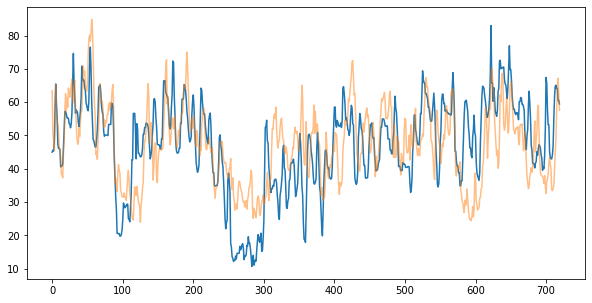

In [0]:
h=30*24
plt.figure(figsize=(10,5))
plt.plot(true_ys[:h])
plt.plot(pred_ys[:h],alpha=.5)

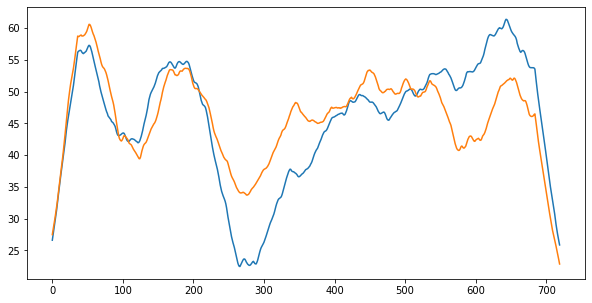

In [0]:
plt.figure(figsize=(10,5))
plt.plot(smooth(true_ys.reshape(-1)[:h],72))
plt.plot(smooth(pred_ys.reshape(-1)[:h],72))

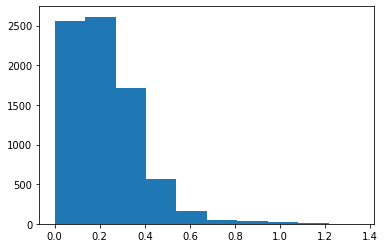

0.22143936810592543

In [0]:
plt.hist(np.abs(true_ys[:h]-pred_ys[:h])/pred_ys[:h])
plt.show()
(np.abs(true_ys[:h]-pred_ys[:h])/pred_ys[:h]).mean()

In [0]:
lookback=128
last_pred_y=ts.df[target_cols].values[ts.ttsplit:ts.ttsplit+1].reshape(-1)
pred_ys_1d=[]
pred_ys_std_1d=[]
true_ys_1d=[]
for i in tqdm(range(ts.ttsplit,ts.df.shape[0])):
  end=i
  start=end-lookback
  X=ts.df.iloc[start:end].copy()
  #X.loc[X.iloc[-1:,:].index,target_cols]=last_pred_y
  X=torch.FloatTensor(X.values).unsqueeze(0).to(device)
  pred_dist=predictor(input_normalizer(X))
  pred_y=output_normalizer.reverse(pred_dist.mean)[0][0].detach().cpu().numpy()
  pred_y_std=output_normalizer.reverse(pred_dist.stddev)[0][0].detach().cpu().numpy()
  y=ts.df[target_cols].values[end:end+1].reshape(-1)
  
  pred_ys_1d.append(pred_y)
  pred_ys_std_1d.append(pred_y_std)
  true_ys_1d.append(y)
  last_pred_y=pred_y

In [0]:
pred_ys_1d=np.array(pred_ys_1d)
pred_ys_std_1d=np.array(pred_ys_std_1d)
true_ys_1d=np.array(true_ys_1d)

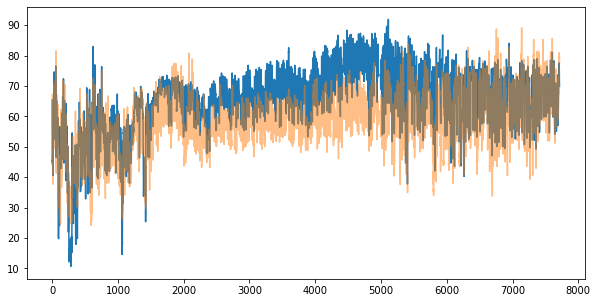

In [0]:
h=14000*24
plt.figure(figsize=(10,5))
plt.plot(true_ys_1d[:h])
plt.plot(pred_ys_1d[:h],alpha=.5)

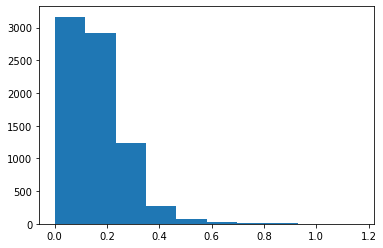

0.15699337129131427

In [0]:
h=10000
plt.hist(np.abs(true_ys_1d[:h]-pred_ys_1d[:h])/pred_ys_1d[:h])
plt.show()
(np.abs(true_ys_1d[:h]-pred_ys_1d[:h])/pred_ys_1d[:h]).mean()

In [0]:
lookback=128
last_pred_y=ts.df[target_cols].values[ts.ttsplit:ts.ttsplit+1].reshape(-1)
pred_ys=[]
pred_ys_std=[]
true_ys=[]
for i in tqdm(range(ts.ttsplit,ts.df.shape[0])):
  end=i
  start=end-lookback
  X=ts.df.iloc[start:end].copy()
  X.loc[X.iloc[-1:,:].index,target_cols]=last_pred_y
  X=torch.FloatTensor(X.values).unsqueeze(0).to(device)
  pred_dist=predictor(input_normalizer(X))
  pred_y=output_normalizer.reverse(pred_dist.mean)[0][0].detach().cpu().numpy()
  pred_y_std=output_normalizer.reverse(pred_dist.stddev)[0][0].detach().cpu().numpy()
  y=ts.df[target_cols].values[end:end+1].reshape(-1)
  
  pred_ys.append(pred_y)
  pred_ys_std.append(pred_y_std)
  true_ys.append(y)
  last_pred_y=pred_y